In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from keras.models import Model
from keras.metrics import MeanIoU
from keras import layers
from keras import backend as K

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
count = 0
for f in os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'):
    count += 1
count

20529

In [3]:
bands = []
bands_idx = ['08', '09', '10', '11', '12', '13', '14', '15', '16']

for i in bands_idx:
    band = np.load(f'/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000603527582775543/band_{i}.npy')
    bands.append(band)
    
bands = np.array(bands)
masks_pxl = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1000603527582775543/human_pixel_masks.npy')
masks_pxl = masks_pxl.astype(np.float32)

In [4]:
bands.shape, masks_pxl.shape

((9, 256, 256, 8), (256, 256, 1))

Text(0.5, 1.0, 'Masked')

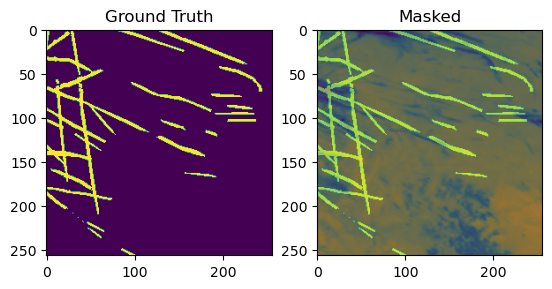

In [5]:
plt.subplot(1, 2, 1)
plt.imshow(masks_pxl)
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(bands[-1][:, :, 0])
plt.imshow(masks_pxl, alpha= 0.5)
plt.title('Masked')

In [6]:
bands.shape, masks_pxl.shape

((9, 256, 256, 8), (256, 256, 1))

In [7]:
masks_pxl_batch = [masks_pxl for _ in range(len(bands))]
masks = np.array(masks_pxl_batch)

In [8]:
bands.shape, masks.shape

((9, 256, 256, 8), (9, 256, 256, 1))

In [9]:
bands_val = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation/1000834164244036115/band_08.npy')
masks_val = np.load('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation/1000834164244036115/human_pixel_masks.npy')

In [10]:
bands_val.shape, masks_val.shape

((256, 256, 8), (256, 256, 1))

Text(0.5, 1.0, 'Masked')

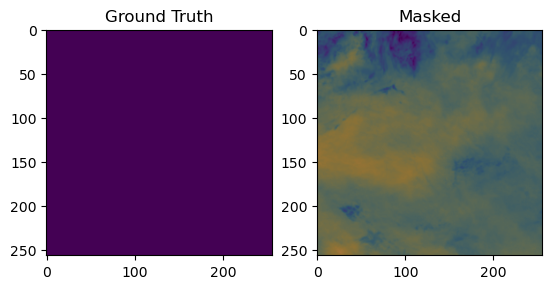

In [11]:
plt.subplot(1, 2, 1)
plt.imshow(masks_val)
plt.title('Ground Truth')

plt.subplot(1, 2, 2)
plt.imshow(bands_val[:, :, 0])
plt.imshow(masks_val, alpha= 0.5)
plt.title('Masked')

In [12]:
class Unet:

    def __init__(self, filter : int = 64) -> None:
        self.FILTER_NUM = filter
    
    def __conv__(self, inputs, num_filters):
        x = layers.Conv2D(num_filters, 3, padding= 'same')(inputs)
        x = layers.BatchNormalization()(x)
        
        shortcut = layers.Conv2D(num_filters, 1, padding= 'same')(inputs)
        shortcut = layers.BatchNormalization()(shortcut)

        res_path = layers.add([shortcut, x])
        res_path = layers.Activation('relu')(res_path)

        return res_path
    
    def __gating__(self, inputs, num_filters):
        x = layers.Conv2D(num_filters, 1, padding= 'same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        return x
    
    def __attn__(self, skip_features, gating, num_filters):
        shape_x = K.int_shape(skip_features)
        shape_g = K.int_shape(gating)

        theta_x = layers.Conv2D(num_filters, 3, strides= 2, padding= 'same')(skip_features)
        shape_theta = K.int_shape(theta_x)

        phi_g = layers.Conv2D(num_filters, 1, padding= 'same')(gating)
        upsample_g = layers.Conv2DTranspose(num_filters, 3,
                                    strides=(shape_theta[1] // shape_g[1], shape_theta[2] // shape_g[2]),
                                    padding='same')(phi_g)

        concat_xg = layers.add([upsample_g, theta_x])
        act_xg = layers.Activation('relu')(concat_xg)

        psi = layers.Conv2D(1, 1, padding= 'same')(act_xg)

        sigmoid_xg = layers.Activation('sigmoid')(psi)
        shape_sigmoid = K.int_shape(sigmoid_xg)

        upsample_psi = layers.UpSampling2D(size= (shape_x[1] // shape_sigmoid[1],
                                           shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
        
        y = layers.multiply([skip_features, upsample_psi])

        result = layers.Conv2D(shape_x[3], 1, padding= 'same')(y)
        result = layers.BatchNormalization()(result)

        return result
    
    def __encoder__(self, inputs, num_filters):
        s = self.__conv__(inputs, num_filters)
        p = layers.MaxPooling2D(2)(s)

        return s, p

    def __decoder__(self, inputs, skip_features, num_filters):
        gating = self.__gating__(inputs, num_filters)
        attn = self.__attn__(skip_features, gating, num_filters)

        d = layers.Conv2DTranspose(num_filters, 3, strides= 2, padding= 'same')(inputs)
        d = layers.Concatenate()([d, attn])
        d = self.__conv__(d, num_filters)

        return d
    
    def gen(self, input_shape : any) -> Model:
        '''
        Generates A Residual Attention UNet Model \n
        '''
        inputs = layers.Input(input_shape)

        # Encoder Block
        s1, p1 = self.__encoder__(inputs, self.FILTER_NUM)
        s2, p2 = self.__encoder__(p1, 2 * self.FILTER_NUM)
        s3, p3 = self.__encoder__(p2, 4 * self.FILTER_NUM)
        s4, p4 = self.__encoder__(p3, 8 * self.FILTER_NUM)

        # Base Block
        b = self.__conv__(p4, 16 * self.FILTER_NUM)

        # Decoder Block
        d1 = self.__decoder__(b, s4, 8 * self.FILTER_NUM)
        d2 = self.__decoder__(d1, s3, 4 * self.FILTER_NUM)
        d3 = self.__decoder__(d2, s2, 2 * self.FILTER_NUM)
        d4 = self.__decoder__(d3, s1, self.FILTER_NUM)

        # Output
        output = layers.Conv2D(1, 1, activation= 'sigmoid', padding= 'same')(d4)
        
        model = Model(inputs, output)        
        return model

In [13]:
model = Unet().gen((256, 256, 8))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 8  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  576         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  4672        ['input_1[0][0]']                
                                )                                                             

In [14]:
path_train = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
path_val = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation'

In [15]:
for f in os.listdir(path_train):
    contrail = path_train + '/' + f
    print(contrail)
    break

/kaggle/input/google-research-identify-contrails-reduce-global-warming/train/1284412112608546821


In [16]:
for f in os.listdir(path_val):
    contrail = path_val + '/' + f
    print(contrail)
    break

/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation/3687499407028137410


In [17]:
model.compile('adam', loss= 'binary_crossentropy', metrics= [MeanIoU(num_classes= 2)])

In [18]:
norm = layers.Rescaling(1./255)

def train():
    count_train = 0 # try for 10 train
    for f_train in os.listdir(path_train):
        if count_train == 10:
            break
        print(f'train: {f_train}')
            
        bands_train = []
        bands_train_idx = ['08', '09', '10', '11', '12', '13', '14', '15', '16']
        contrail_train = path_train + '/' + f_train

        for i in bands_train_idx:
            band = np.load(f'{contrail_train}/band_{i}.npy')
            bands_train.append(band)

        bands_train = np.array(bands_train)
        
        masks_pxl_train = np.load(f'{contrail_train}/human_pixel_masks.npy')
        masks_pxl_train_batch = [masks_pxl_train for _ in range(len(bands_train))]
        masks_train = np.array(masks_pxl_train_batch)
                
        ds_train = tf.data.Dataset.from_tensor_slices((bands_train, masks_train))
                     
        ds_train = ds_train.batch(9)
        ds_train = ds_train.map(lambda x, y: (norm(x), y), num_parallel_calls= tf.data.AUTOTUNE)
        ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
        
        count_val = 0 # try for 10 validation
        for f_val in os.listdir(path_val):
            if count_val == 10:
                break
            print(f'validation: {f_val}')

            bands_val = []
            bands_val_idx = ['08', '09', '10', '11', '12', '13', '14', '15', '16']
            contrail_val = path_val + '/' + f_val

            for i in bands_val_idx:
                band = np.load(f'{contrail_val}/band_{i}.npy')
                bands_val.append(band)

            bands_val = np.array(bands_val)

            masks_pxl_val = np.load(f'{contrail_val}/human_pixel_masks.npy')
            masks_pxl_val_batch = [masks_pxl_val for _ in range(len(bands_val))]
            masks_val = np.array(masks_pxl_val_batch)

            ds_val = tf.data.Dataset.from_tensor_slices((bands_val, masks_val))

            ds_val = ds_val.batch(9)
            ds_val = ds_val.map(lambda x, y: (norm(x), y), num_parallel_calls= tf.data.AUTOTUNE)
            ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

            model.fit(ds_train,
                      epochs= 2,
                      verbose= 1,
                      validation_data= ds_val)
            
            count_val += 1

        count_train += 1

In [19]:
train()

train: 1284412112608546821
validation: 3687499407028137410
Epoch 1/2
1/1 [==============================] - 42s 42s/step - loss: 1.0978 - mean_io_u: 1.0000 - val_loss: 0.4398 - val_mean_io_u: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 493ms/step - loss: 0.5563 - mean_io_u: 1.0000 - val_loss: 0.2753 - val_mean_io_u: 1.0000
validation: 6558861185867890815
Epoch 1/2
1/1 [==============================] - 1s 556ms/step - loss: 0.2946 - mean_io_u: 1.0000 - val_loss: 0.2811 - val_mean_io_u: 0.4972
Epoch 2/2
1/1 [==============================] - 0s 493ms/step - loss: 0.1851 - mean_io_u: 1.0000 - val_loss: 0.2153 - val_mean_io_u: 0.4972
validation: 7355354609194882312
Epoch 1/2
1/1 [==============================] - 1s 528ms/step - loss: 0.1307 - mean_io_u: 1.0000 - val_loss: 0.0965 - val_mean_io_u: 1.0000
Epoch 2/2
1/1 [==============================] - 0s 478ms/step - loss: 0.1026 - mean_io_u: 1.0000 - val_loss: 0.0348 - val_mean_io_u: 1.0000
validation: 7547747455642200110


In [20]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [21]:
def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [22]:
test_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'
pred_masks = {'record_id': [],
             'encoded_pixels': []}
for f in os.listdir(test_path):
    print(f)
    
    bands_test = []

    band_test = np.load(f'{test_path}/{f}/band_08.npy')
    bands_test.append(band_test)
    bands_test = np.array(bands_test)
    
    pred = model.predict(bands_test)
    
    pred_masks['record_id'].append(f)
    pred_masks['encoded_pixels'].append(list_to_string(rle_encode(pred)))

1002653297254493116
1/1 [==============================] - 2s 2s/step
1000834164244036115
1/1 [==============================] - 0s 23ms/step


In [23]:
pred_masks

{'record_id': ['1002653297254493116', '1000834164244036115'],
 'encoded_pixels': ['-', '-']}

In [24]:
sample = pd.read_csv('/kaggle/input/google-research-identify-contrails-reduce-global-warming/sample_submission.csv')
sample.head()

,record_id,encoded_pixels
0,1000834164244036115,1 3 10 5
1,1002653297254493116,-


In [25]:
submission = pd.DataFrame.from_dict(pred_masks)
submission.head()

,record_id,encoded_pixels
0,1002653297254493116,-
1,1000834164244036115,-


In [26]:
submission.to_csv('submission.csv')